<a href="https://colab.research.google.com/github/chenalan02/Discord-Message-Sender-Classifier/blob/main/Discord_Message_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

uploaded = files.upload()

Saving data_long.csv to data_long.csv


In [ ]:
data = pd.read_csv('data_long.csv')
data.head()

,Unnamed: 0,content,author
0,NaN,NaN,NaN
1,1.0,i forgot the other 2 nvm,tree.
2,2.0,i just remember cus he typed it,tree.
3,3.0,and he started counting the rounds after im pr...,tree.
4,4.0,this is the sage that we 12-0 first half,tree.


In [ ]:
data = data.dropna()
data.head()

,Unnamed: 0,content,author
1,1.0,i forgot the other 2 nvm,tree.
2,2.0,i just remember cus he typed it,tree.
3,3.0,and he started counting the rounds after im pr...,tree.
4,4.0,this is the sage that we 12-0 first half,tree.
5,5.0,it only works when i do it,Alan


In [ ]:
def author_indexing(author):
  if author == "Alan":
    return 0
  if author == "nicholas":
    return 1
  if author == "tree.":
    return 2
  if author == "Jason4Hear":
    return 3
  if author == "jaden":
    return 4

data["author idx"] = data['author'].apply(author_indexing)
data = data.dropna()
data = data.drop(["Unnamed: 0"], axis = 1)

In [ ]:
data = data[data["content"].str.split().str.len() > 9]
data.groupby("author").count()

,content,author idx
author,,
Alan,479,479
Jason4Hear,434,434
jaden,560,560
nicholas,1074,1074
tree.,592,592


In [ ]:
data = data.sort_values("author idx")
data = data.drop(data.index[479:479+500], axis = 0)
data.groupby("author").count()

,content,author idx
author,,
Alan,479,479
Jason4Hear,434,434
jaden,560,560
nicholas,574,574
tree.,592,592


In [ ]:
X = data["content"]
Y = data["author idx"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

print(len(set(X_train)))

944


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

word_to_idx = tokenizer.word_index
unique_tokens = len(word_to_idx)
print(unique_tokens)

3715


In [ ]:
X_train = pad_sequences(sequences_train, maxlen = 123)
X_test = pad_sequences(sequences_test, maxlen = 123)
print(X_train.shape)
print(X_test.shape)

(1319, 123)
(1320, 123)


In [ ]:
#embedding dimensionality
D = 70
T = 123
#hidden state dimensionality
M = 40

# we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0 (0 is reserved for empty spaces in padding)
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(unique_tokens + 1, D)(i)
x = LSTM(M)(x)
x = Dense(5, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)

r = model.fit(
  X_train,
  Y_train,
  epochs=20,
  validation_data=(X_test, Y_test),
  callbacks = [callback]
)

Epoch 1/20
42/42 [==============================] - 2s 20ms/step - loss: 1.5385 - accuracy: 0.4276 - val_loss: 1.3740 - val_accuracy: 0.4742
Epoch 2/20
42/42 [==============================] - 0s 10ms/step - loss: 1.1893 - accuracy: 0.6224 - val_loss: 1.0858 - val_accuracy: 0.6402
Epoch 3/20
42/42 [==============================] - 0s 10ms/step - loss: 0.8867 - accuracy: 0.7225 - val_loss: 0.9680 - val_accuracy: 0.6439
Epoch 4/20
42/42 [==============================] - 0s 10ms/step - loss: 0.6145 - accuracy: 0.8014 - val_loss: 0.9929 - val_accuracy: 0.6515
Epoch 5/20
42/42 [==============================] - 0s 10ms/step - loss: 0.3802 - accuracy: 0.8954 - val_loss: 0.9531 - val_accuracy: 0.6644
Epoch 6/20
42/42 [==============================] - 0s 10ms/step - loss: 0.2311 - accuracy: 0.9515 - val_loss: 1.0059 - val_accuracy: 0.6705
Epoch 7/20
42/42 [==============================] - 0s 11ms/step - loss: 0.1561 - accuracy: 0.9750 - val_loss: 1.0490 - val_accuracy: 0.6705
Epoch 8/20
42

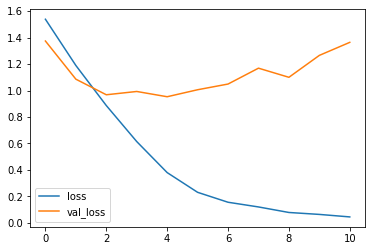

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

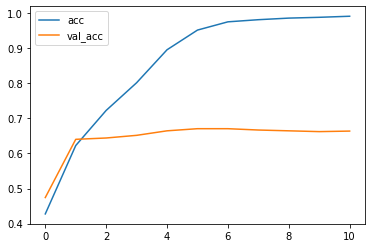

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

Confusion matrix, without normalization
[[134  47   7   8  41]
 [  7 227   4   8  48]
 [  2  25 233   9  45]
 [  2  26   4 133  41]
 [ 11  64  14  22 158]]


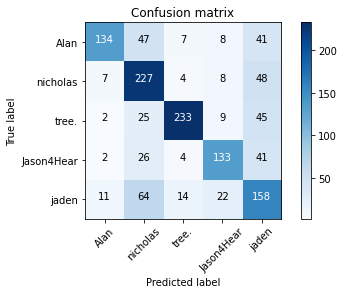

(None,)

In [ ]:
# Plot confusion matrix
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, model.predict(X_test).argmax(axis=1))
plot_confusion_matrix(cm, ["Alan", "nicholas", "tree.", "Jason4Hear", 'jaden']), 

In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''  
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
'''

"  \nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n"

In [ ]:
model.save('Discord Message Classifier 67%.h5')
!ls

 data_long.csv			      sample_data
'Discord Message Classifier 67%.h5'   tokenizer.pickle
